## CyberLab session clustering notebook

After performing an EDA which resulted in Tukey filtering on both (i) within-session time_diffs (upper fence) and (ii) population-wide SPC (upper fence), we can proceed to cluster the cleaned session-level features.

- Pulls session-level features from CyberLab after Tukey filtering on time_diff
- File: cyberlab_session_features_tukey_time_ts.csv
- Performs KMeans clustering (excluding SQL injection sample)
- Uses elbow + silhouette to pick k
- Visualises clusters in PCA space

In [11]:
# Imports & plotting style

import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from math import pi

# HARD RESET OF STYLE
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("default")
sns.set_theme(style="whitegrid")

plt.rcParams.update({
    "figure.max_open_warning": 0,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
})

os.makedirs("output", exist_ok=True)


In [12]:
# Load session-level features & basic info

SESSION_FEATURES_PATH = "output/cyberlab_clustering_features.csv"

df_sess = pd.read_csv(SESSION_FEATURES_PATH)

print("=== Loaded session-level features ===")
print(f"Rows (sessions): {len(df_sess):,}")
print(f"Columns: {list(df_sess.columns)}\n")

# Parse timestamps (not strictly needed for clustering, but useful)
for col in ["session_start", "session_end"]:
    if col in df_sess.columns:
        df_sess[col] = pd.to_datetime(
            df_sess[col],
            utc=True,
            format="mixed",
            errors="coerce",
        )

print("=== Per-sample session counts (ALL samples) ===")
print(df_sess["sample"].value_counts())


=== Loaded session-level features ===
Rows (sessions): 166
Columns: ['sample', 'sandbox_id', 'n_pairs', 'session_start', 'session_end', 'mean_ts', 'median_ts', 'std_ts', 'min_ts', 'max_ts', 'mean_dt', 'median_dt', 'std_dt', 'min_dt', 'max_dt', 'mean_len', 'median_len', 'std_len', 'min_len', 'max_len', 'mean_spc_pairs', 'median_spc_pairs', 'std_spc_pairs', 'session_duration_s', 'total_time_diff', 'total_cmd_len', 'avg_time_per_char', 'mean_spc', 'median_spc', 'std_spc', 'mean_cps', 'std_cps']

=== Per-sample session counts (ALL samples) ===
sample
Junior hacker adaptive     56
Kobylka 3302               44
House of cards             22
Junior hacker              18
Secret laboratory          13
Webmin exploit practice     9
SQL injection               4
Name: count, dtype: int64


In [13]:
# Drop SQL injection sessions

df_clust = df_sess[df_sess["sample"] != "SQL injection"].copy()

# Uncomment below if you want to retain SQL injection for clustering
# df_clust = df_sess.copy()

print("=== Per-sample session counts (excluding SQL injection) ===")
print(df_clust["sample"].value_counts())
print(f"\nSessions retained for clustering: {len(df_clust):,}")


=== Per-sample session counts (excluding SQL injection) ===
sample
Junior hacker adaptive     56
Kobylka 3302               44
House of cards             22
Junior hacker              18
Secret laboratory          13
Webmin exploit practice     9
Name: count, dtype: int64

Sessions retained for clustering: 162


In [14]:
# Select core features for clustering

# Features chosen to capture:
# - median typing speed and delay (robust to outliers)
# - total "volume" (n_pairs)
# - typical command length (median_len)
# - SPC-based behaviour (mean_spc, std_spc, avg_time_per_char)

features = [
    "median_ts",        # speed (chars/s)
    "median_dt",        # thinking time (s)
    "n_pairs",          # session volume
    "median_len",       # typical command length
    "mean_spc",         # mean seconds per char (from SPC-based stats)
    "std_spc",          # variability in seconds per char
    "avg_time_per_char" # sum(time_diff) / sum(cmd_length)
]

# Keep only those columns that actually exist (defensive)
features = [c for c in features if c in df_clust.columns]

print("Using features for clustering:")
for f in features:
    print("  -", f)

X = df_clust[features].copy()

# Quick summary
print("\n=== Summary of selected features (raw space) ===")
display(X.describe().T.round(3))


Using features for clustering:
  - median_ts
  - median_dt
  - n_pairs
  - median_len
  - mean_spc
  - std_spc
  - avg_time_per_char

=== Summary of selected features (raw space) ===


,count,mean,std,min,25%,50%,75%,max
median_ts,162.0,106.090,1222.791,0.101,0.584,0.871,1.409,15500.000
median_dt,162.0,20.287,21.386,0.001,8.000,14.840,27.780,208.890
n_pairs,162.0,67.321,44.353,3.000,37.000,57.000,88.750,306.000
median_len,162.0,13.806,8.052,4.000,10.000,12.500,16.000,64.000
mean_spc,162.0,3.453,2.117,0.550,1.751,2.905,4.681,9.857
std_spc,162.0,6.110,4.327,0.848,2.820,5.003,8.804,25.683
avg_time_per_char,162.0,2.093,1.451,0.126,1.013,1.682,2.809,7.949


In [15]:
# Log-transform skewed features (time + counts + SPC)

# These are expected to be heavy-tailed, so we work in log-space
log_features = [
    "n_pairs",
    "median_dt",
    "median_ts",
    "mean_spc",
    "std_spc",
    "avg_time_per_char",
]
log_features = [c for c in log_features if c in X.columns]

for col in log_features:
    # log1p handles zeros safely; SPC should be > 0 but this keeps things robust
    X[col] = np.log1p(X[col])

print("Log-transformed columns:", log_features)

print("\n=== Summary of features after log-transform (where applied) ===")
display(X.describe().T.round(3))


Log-transformed columns: ['n_pairs', 'median_dt', 'median_ts', 'mean_spc', 'std_spc', 'avg_time_per_char']

=== Summary of features after log-transform (where applied) ===


,count,mean,std,min,25%,50%,75%,max
median_ts,162.0,0.768,0.925,0.096,0.460,0.627,0.879,9.649
median_dt,162.0,2.754,0.787,0.001,2.197,2.763,3.359,5.347
n_pairs,162.0,4.004,0.728,1.386,3.638,4.060,4.497,5.727
median_len,162.0,13.806,8.052,4.000,10.000,12.500,16.000,64.000
mean_spc,162.0,1.386,0.465,0.438,1.012,1.362,1.737,2.385
std_spc,162.0,1.789,0.591,0.614,1.340,1.792,2.283,3.284
avg_time_per_char,162.0,1.038,0.417,0.119,0.700,0.987,1.337,2.192


In [16]:
# Standardise features

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled feature matrix shape:", X_scaled.shape)


Scaled feature matrix shape: (162, 7)


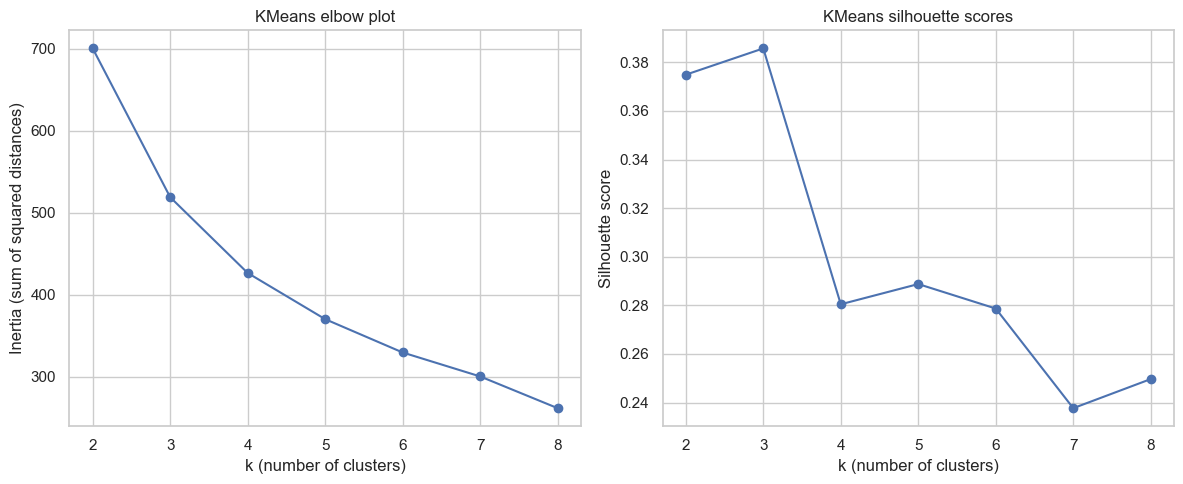

k=2: inertia=700.6, silhouette=0.375
k=3: inertia=518.9, silhouette=0.386
k=4: inertia=426.5, silhouette=0.280
k=5: inertia=370.1, silhouette=0.289
k=6: inertia=329.4, silhouette=0.279
k=7: inertia=300.1, silhouette=0.238
k=8: inertia=261.4, silhouette=0.250

Chosen number of clusters (max silhouette): k = 3


In [17]:
# KMeans model selection with elbow + silhouette

k_range = range(2, 9)
inertias = []
sil_scores = []

for k in k_range:
    kmeans_k = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10,
    )
    labels_k = kmeans_k.fit_predict(X_scaled)
    inertias.append(kmeans_k.inertia_)
    sil = silhouette_score(X_scaled, labels_k)
    sil_scores.append(sil)

# Plot elbow (inertia) and silhouette
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Elbow
ax[0].plot(list(k_range), inertias, marker="o")
ax[0].set_xlabel("k (number of clusters)")
ax[0].set_ylabel("Inertia (sum of squared distances)")
ax[0].set_title("KMeans elbow plot")

# Silhouette
ax[1].plot(list(k_range), sil_scores, marker="o")
ax[1].set_xlabel("k (number of clusters)")
ax[1].set_ylabel("Silhouette score")
ax[1].set_title("KMeans silhouette scores")

plt.tight_layout()
plt.savefig("output/kmeans_elbow_silhouette.png", dpi=150)
plt.show()

for k, inert, sil in zip(k_range, inertias, sil_scores):
    print(f"k={k}: inertia={inert:.1f}, silhouette={sil:.3f}")

# Choose best k as the one with the highest silhouette score
best_k = int(k_range[int(np.argmax(sil_scores))])
print(f"\nChosen number of clusters (max silhouette): k = {best_k}")


In [18]:
# Fit final KMeans model with chosen k and assign clusters

kmeans = KMeans(
    n_clusters=5,
    random_state=42,
    n_init=10,
)
cluster_labels = kmeans.fit_predict(X_scaled)

df_clust["cluster"] = cluster_labels

print("=== Cluster counts ===")
print(df_clust["cluster"].value_counts().sort_index())


=== Cluster counts ===
cluster
0    53
1    62
2     2
3     2
4    43
Name: count, dtype: int64


In [19]:
# Interactive PCA plot

import plotly.express as px

pca = PCA(n_components=2, random_state=5)
X_pca = pca.fit_transform(X_scaled)

df_clust["PCA1"] = X_pca[:, 0]
df_clust["PCA2"] = X_pca[:, 1]

print("Explained variance ratio:", pca.explained_variance_ratio_)

# Hoverable columns (SPC-aware, prop_* removed)
hover_cols = [
    "sample",
    "sandbox_id",
    "cluster",
    "mean_ts",
    "mean_dt",
    "median_ts",
    "median_dt",
    "n_pairs",
    "median_len",
    "mean_spc",
    "std_spc",
    "avg_time_per_char",
]

hover_cols = [c for c in hover_cols if c in df_clust.columns]

fig = px.scatter(
    df_clust,
    x="PCA1",
    y="PCA2",
    color="cluster",
    hover_data=hover_cols,
    title="CyberLab sessions - KMeans clusters in PCA space (interactive)",
    width=900,
    height=650,
)

fig.update_traces(marker=dict(size=9, opacity=0.8))
fig.update_layout(
    template="simple_white",
    legend_title_text="cluster",
)

fig.show()

# Save HTML
fig.write_html("output/cyberlab_clusters_pca_interactive.html", include_plotlyjs="cdn")


Explained variance ratio: [0.55670859 0.18515345]


## Cluster interpretation via z-scores

- Cell below is primarily for cluster interpretation.
- That is, what is the core feature within each cluster relative to the overall dataset?
- Feature = HIGH indicates cluster mean is above global mean. Aka, this feature is a defining characteristic of the cluster.
- Feature = LOW indicates cluster mean is below global mean. Aka, this feature is less prominent in this cluster.

In [20]:
from IPython.display import display

features_for_z = [
    "median_ts",
    "median_dt",
    "n_pairs",
    "median_len",
    "mean_spc",
    "std_spc",
    "avg_time_per_char",
]
features_for_z = [c for c in features_for_z if c in df_clust.columns]

# Global stats
global_mean = df_clust[features_for_z].mean()
global_std  = df_clust[features_for_z].std()

# Cluster-wise means
cluster_means = df_clust.groupby("cluster")[features_for_z].mean()

# Z-scores: how many std deviations each cluster is above/below global mean
cluster_z = (cluster_means - global_mean) / global_std

print("=== Cluster-wise z-scores (feature means relative to global mean) ===")
display(cluster_z.round(2))

# For each cluster, print the most distinctive features
for k, row in cluster_z.iterrows():
    print(f"\n=== Cluster {k} - most distinctive features ===")
    # sort by absolute z-score descending
    top = row.reindex(features_for_z).abs().sort_values(ascending=False)
    for feat in top.index[:5]:
        z = row[feat]
        direction = "HIGH" if z > 0 else "LOW"
        print(f"  {feat:18s}: {direction:4s} (z = {z:+.2f})")


=== Cluster-wise z-scores (feature means relative to global mean) ===


,median_ts,median_dt,n_pairs,median_len,mean_spc,std_spc,avg_time_per_char
cluster,,,,,,,
0,-0.09,-0.09,-0.13,-0.14,-0.01,0.06,-0.06
1,-0.09,-0.58,0.59,-0.33,-0.86,-0.76,-0.75
2,6.87,-0.95,0.62,3.25,-1.35,-1.11,-1.22
3,-0.08,0.18,-0.30,4.93,-0.99,-0.92,-0.83
4,-0.09,0.98,-0.70,0.27,1.36,1.12,1.26



=== Cluster 0 - most distinctive features ===
  median_len        : LOW  (z = -0.14)
  n_pairs           : LOW  (z = -0.13)
  median_dt         : LOW  (z = -0.09)
  median_ts         : LOW  (z = -0.09)
  std_spc           : HIGH (z = +0.06)

=== Cluster 1 - most distinctive features ===
  mean_spc          : LOW  (z = -0.86)
  std_spc           : LOW  (z = -0.76)
  avg_time_per_char : LOW  (z = -0.75)
  n_pairs           : HIGH (z = +0.59)
  median_dt         : LOW  (z = -0.58)

=== Cluster 2 - most distinctive features ===
  median_ts         : HIGH (z = +6.87)
  median_len        : HIGH (z = +3.25)
  mean_spc          : LOW  (z = -1.35)
  avg_time_per_char : LOW  (z = -1.22)
  std_spc           : LOW  (z = -1.11)

=== Cluster 3 - most distinctive features ===
  median_len        : HIGH (z = +4.93)
  mean_spc          : LOW  (z = -0.99)
  std_spc           : LOW  (z = -0.92)
  avg_time_per_char : LOW  (z = -0.83)
  n_pairs           : LOW  (z = -0.30)

=== Cluster 4 - most distinctiv

In [21]:
from IPython.display import display
import numpy as np

def describe_cluster_medoids(
    df_clust,
    X_scaled,
    kmeans,
    feature_cols=None,
):

    if "cluster" not in df_clust.columns:
        raise ValueError("df_clust must contain a 'cluster' column.")

    labels = df_clust["cluster"].to_numpy()
    unique_clusters = np.unique(labels)

    if feature_cols is None:
        feature_cols = [
            "n_pairs",
            "session_duration_s",
            "mean_ts", "median_ts", "std_ts",
            "mean_dt", "median_dt", "std_dt",
            "mean_len", "median_len", "std_len",
            "mean_spc", "median_spc", "std_spc",
            "avg_time_per_char",
        ]
    feature_cols = [c for c in feature_cols if c in df_clust.columns]

    medoid_rows = []

    for k in sorted(unique_clusters):
        mask = labels == k
        X_k = X_scaled[mask]
        df_k = df_clust.loc[mask].copy()

        if len(df_k) == 0:
            continue

        center_k = kmeans.cluster_centers_[k]

        # Euclidean distances in scaled feature space
        dists = np.linalg.norm(X_k - center_k, axis=1)
        idx_min = int(np.argmin(dists))

        medoid = df_k.iloc[idx_min]

        print(f"\n=== Cluster {k} medoid session ===")
        print(f" sample       : {medoid.get('sample')}")
        print(f" sandbox_id   : {medoid.get('sandbox_id')}")
        print(f" dist to center (scaled space): {dists[idx_min]:.3f}")
        if "n_pairs" in medoid.index:
            print(f" n_pairs      : {medoid.get('n_pairs')}")
        if "session_duration_s" in medoid.index:
            print(f" duration (s) : {medoid.get('session_duration_s'):.2f}")

        print(" key metrics (original units):")
        for col in [
            "mean_ts", "median_ts",
            "mean_dt", "median_dt",
            "mean_len", "median_len",
            "mean_spc", "median_spc",
            "avg_time_per_char",
        ]:
            if col in medoid.index:
                print(f"  {col:18s} = {medoid[col]:.4f}")

        # Collect into a dict for the summary DataFrame
        row = {
            "cluster": k,
            "sample": medoid.get("sample"),
            "sandbox_id": medoid.get("sandbox_id"),
            "dist_to_center": dists[idx_min],
        }
        for col in feature_cols:
            row[col] = medoid.get(col)
        medoid_rows.append(row)

    df_medoids = pd.DataFrame(medoid_rows)
    df_medoids = df_medoids.sort_values("cluster").reset_index(drop=True)

    print("\n=== Medoid summary table (one row per cluster) ===")
    display(df_medoids.round(4))

    return df_medoids


In [22]:
df_medoids = describe_cluster_medoids(
    df_clust,
    X_scaled,
    kmeans,
)


=== Cluster 0 medoid session ===
 sample       : Kobylka 3302
 sandbox_id   : 185
 dist to center (scaled space): 0.556
 n_pairs      : 75
 duration (s) : 4624.00
 key metrics (original units):
  mean_ts            = 1.1268
  median_ts          = 0.6667
  mean_dt            = 26.1600
  median_dt          = 20.0000
  mean_len           = 12.9467
  median_len         = 11.0000
  mean_spc           = 2.9455
  median_spc         = 1.5000
  avg_time_per_char  = 2.0206

=== Cluster 1 medoid session ===
 sample       : Junior hacker adaptive
 sandbox_id   : 122
 dist to center (scaled space): 0.155
 n_pairs      : 85
 duration (s) : 3073.94
 key metrics (original units):
  mean_ts            = 307.9413
  median_ts          = 1.7116
  mean_dt            = 16.3790
  median_dt          = 7.6100
  mean_len           = 17.3882
  median_len         = 12.0000
  mean_spc           = 1.5881
  median_spc         = 0.5843
  avg_time_per_char  = 0.9420

=== Cluster 2 medoid session ===
 sample       : J

,cluster,sample,sandbox_id,dist_to_center,n_pairs,session_duration_s,mean_ts,median_ts,std_ts,mean_dt,median_dt,std_dt,mean_len,median_len,std_len,mean_spc,median_spc,std_spc,avg_time_per_char
0,0,Kobylka 3302,185,0.5560,75,4624.0000,1.1268,0.6667,1.1493,26.1600,20.0000,25.1100,12.9467,11.0,11.0587,2.9455,1.5000,5.9019,2.0206
1,1,Junior hacker adaptive,122,0.1551,85,3073.9420,307.9413,1.7116,2005.7663,16.3790,7.6100,20.4481,17.3882,12.0,17.0957,1.5881,0.5843,2.5925,0.9420
2,2,Junior hacker adaptive,70,4.1082,4,1019.8930,13000.0988,15500.0000,9486.6524,8.2238,0.0010,16.4455,16.2500,16.0,4.4253,0.6326,0.0001,1.2650,0.5061
3,3,Kobylka 3302,50,2.0467,11,2308.2105,5.2181,1.5458,12.1145,62.0852,37.5198,65.7801,42.3636,48.0,20.8532,1.9688,0.6469,2.0393,1.4655
4,4,House of cards,130,0.6084,30,374943.3742,0.7289,0.4076,0.8058,52.8353,33.2507,55.6583,12.8667,12.0,9.2242,5.4504,2.4610,9.1886,4.1064


# TODO: Fill in after analysing medoids and cluster z-scores

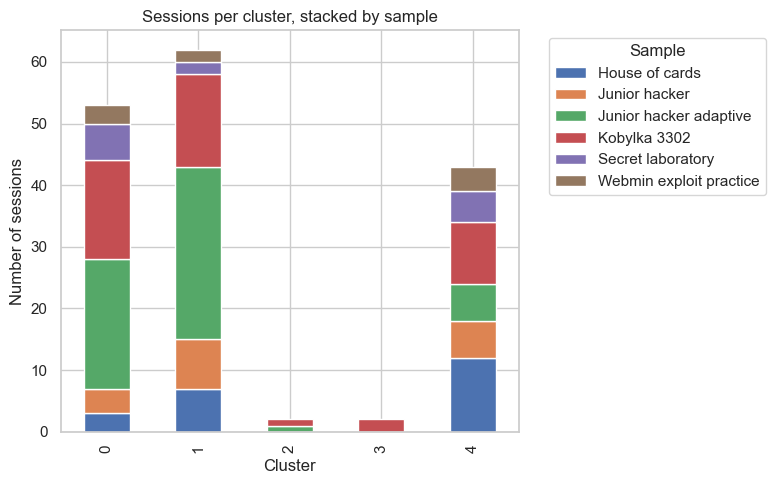

sample,House of cards,Junior hacker,Junior hacker adaptive,Kobylka 3302,Secret laboratory,Webmin exploit practice
cluster,,,,,,
0,0.057,0.075,0.396,0.302,0.113,0.057
1,0.113,0.129,0.452,0.242,0.032,0.032
2,0.000,0.000,0.500,0.500,0.000,0.000
3,0.000,0.000,0.000,1.000,0.000,0.000
4,0.279,0.140,0.140,0.233,0.116,0.093


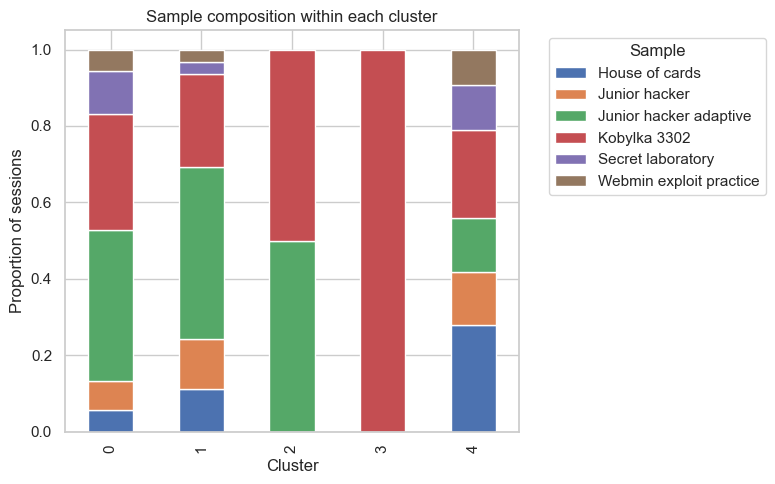

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Crosstab: cluster x sample
ct_counts = pd.crosstab(df_clust["cluster"], df_clust["sample"]).sort_index()

# display(ct_counts)

# Plot: stacked bar (counts)
plt.figure(figsize=(8, 5))
ct_counts.plot(
    kind="bar",
    stacked=True,
    ax=plt.gca()
)
plt.xlabel("Cluster")
plt.ylabel("Number of sessions")
plt.title("Sessions per cluster, stacked by sample")
plt.legend(title="Sample", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

ct_props = ct_counts.div(ct_counts.sum(axis=1), axis=0)

display(ct_props.round(3))

plt.figure(figsize=(8, 5))
ct_props.plot(
    kind="bar",
    stacked=True,
    ax=plt.gca()
)
plt.xlabel("Cluster")
plt.ylabel("Proportion of sessions")
plt.title("Sample composition within each cluster")
plt.legend(title="Sample", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
